In [1]:
import numpy as np
# from basicpy import BaSiC
from scipy.ndimage import zoom
import zarr
# from numcodecs import GZip 

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
def transform(images, f, d=None):
    if d is not None:
        images_transformed = (np.clip(images-d[np.newaxis],0,None))/f[np.newaxis]
    else:
        images_transformed = images/f[np.newaxis]
        
    return images_transformed

In [4]:
def plot(dx, ff):
    fig, axs = plt.subplots(1,2,figsize=(8*2, 6))
    ax = axs[0]
    g = ax.imshow(dx, cmap='coolwarm') #, vmin=0, vmax=2)
    ax.set_title('dark-field')
    plt.colorbar(g)
    ax = axs[1]
    g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
    ax.set_title('flat-field')
    fig.colorbar(g)
    plt.show()


In [5]:
def transform_pipe(images_raw, dx, ff, upscale=8):
    """
    """
    ff_s = zoom(ff, upscale).astype(np.float16)
    dx_s = zoom(dx, upscale).astype(np.float16)
    images_s_transformed = transform(images_raw.astype(np.float16), ff_s, d=dx_s).astype(np.uint16)
    return images_s_transformed

In [6]:
path = "/u/scratch/f/f7xiesnm/sparse06/dataset.n5"
outpath = "/u/home/f/f7xiesnm/project-zipursky/data/hold/sparse06/r1_test_flatfield_v7.n5"
zarr_data = zarr.open(store=zarr.N5Store(path), mode='r')

In [7]:
# list(zarr_data.keys())

In [8]:
print(zarr_data[f'/setup0/timepoint0/s0'].shape)
print(zarr_data[f'/setup0/timepoint0/s1'].shape)
print(zarr_data[f'/setup0/timepoint0/s2'].shape)
print(zarr_data[f'/setup0/timepoint0/s3'].shape)
print(zarr_data[f'/setup0/timepoint0/s4'].shape)

(2837, 1920, 1920)
(2837, 960, 960)
(1418, 480, 480)
(709, 240, 240)
(354, 120, 120)


In [9]:
import tifffile
dx = tifffile.imread('/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield/darkfield_rb.tiff').astype(np.float32)
ff = tifffile.imread('/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield/flatfield_rb.tiff').astype(np.float32)

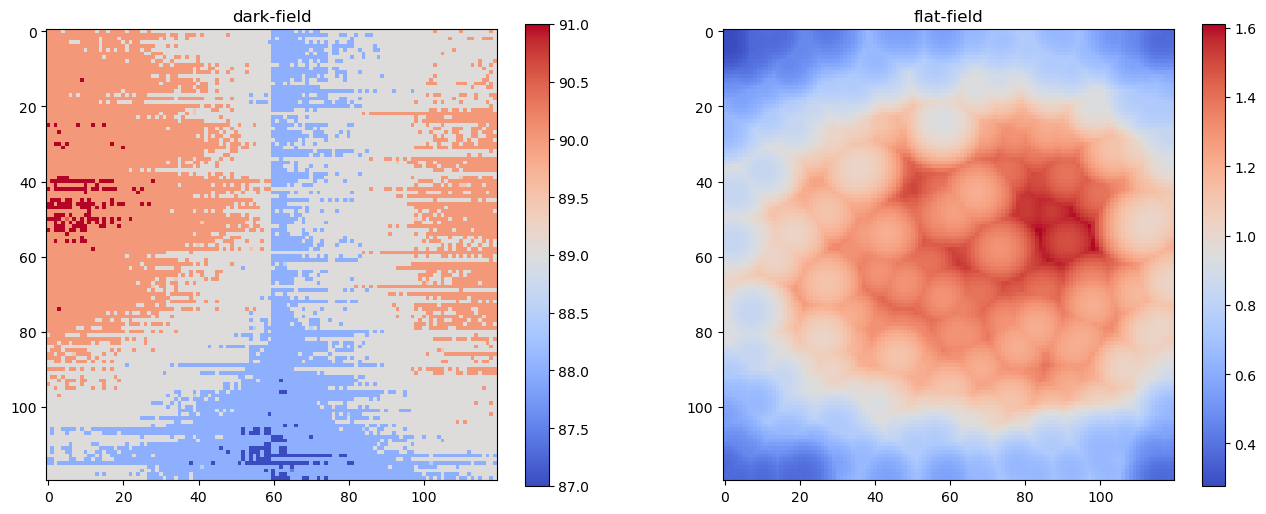

In [10]:
plot(dx, ff)

In [11]:
slot = f'/setup13/timepoint0/s3'
images_s0_handle  = zarr_data[slot]
attributes = images_s0_handle.attrs.asdict()
attributes['pixelResolution'] = [0.23, 0.23, 0.42] # useful later
print(attributes)

{'downsamplingFactors': [8, 8, 4], 'pixelResolution': [0.23, 0.23, 0.42]}


In [12]:
images_s0_handle.compressor

N5ChunkWrapper(chunk_shape=(64, 128, 128), compressor_config={'id': 'gzip', 'level': -1}, dtype=dtype('uint16'))

In [13]:
n5_root = zarr.open_group(store=zarr.N5Store(outpath), mode='w')

# c0_corrected

In [14]:
%%time
images_s0_raw = images_s0_handle[...]

CPU times: user 339 ms, sys: 51.8 ms, total: 391 ms
Wall time: 782 ms


In [15]:
%%time
a = transform_pipe(images_s0_raw, dx, ff, upscale=2)

CPU times: user 1.51 s, sys: 189 ms, total: 1.7 s
Wall time: 1.7 s


In [16]:
%%time
dataset = n5_root.require_dataset(
    slot,
    data=a,
    shape=a.shape,
    chunks=images_s0_handle.chunks,
    dtype=images_s0_handle.dtype,
    compressor=images_s0_handle.compressor, # GZip(level=1),
)
# set additional attributes
dataset.attrs.update(**attributes)

n5_root[slot]

CPU times: user 6.55 s, sys: 64.6 ms, total: 6.61 s
Wall time: 7.29 s


<zarr.core.Array '/setup13/timepoint0/s3' (709, 240, 240) uint16>

In [17]:
print(n5_root[slot])

<zarr.core.Array '/setup13/timepoint0/s3' (709, 240, 240) uint16>
